# Crunch raw CMIP6 data

Here we calculate the country-means.

In [1]:
%load_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
import glob
import logging

import iris.analysis
import iris.quickplot as qplt
import matplotlib.pyplot as plt
import netcdf_scm
import netcdf_scm.crunching
import netcdf_scm.weights
import numpy as np
import pandas as pd
import regionmask
import xarray as xr
from netcdf_scm.iris_cube_wrappers import CMIP6OutputCube

<IPython.core.display.Javascript object>

In [3]:
NETCDF_SCM_LOGGER = logging.getLogger("netcdf_scm")

<IPython.core.display.Javascript object>

In [4]:
STDERR_INFO_HANDLER = logging.StreamHandler()
FORMATTER = logging.Formatter(
    "%(asctime)s %(name)s %(threadName)s - %(levelname)s:  %(message)s",
    datefmt="%Y-%m-%d %H:%M:%S",
)
STDERR_INFO_HANDLER.setFormatter(FORMATTER)
STDERR_INFO_HANDLER.setLevel(logging.INFO)

<IPython.core.display.Javascript object>

In [5]:
NETCDF_SCM_LOGGER.setLevel(logging.DEBUG)
NETCDF_SCM_LOGGER.addHandler(STDERR_INFO_HANDLER)

<IPython.core.display.Javascript object>

In [6]:
netcdf_scm.__version__

'2.1.0'

<IPython.core.display.Javascript object>

In [7]:
!find /data/cmip6/CMIP6/ScenarioMIP -mindepth 2 -maxdepth 2 -type d -exec sh -c 'x={};echo $(basename ${x})' \; | sort

ACCESS-CM2
ACCESS-ESM1-5
AWI-CM-1-1-MR
BCC-CSM2-MR
CAMS-CSM1-0
CanESM5
CanESM5-CanOE
CAS-ESM2-0
CESM2
CESM2-WACCM
CIESM
CMCC-CM2-SR5
CMCC-ESM2
CNRM-CM6-1
CNRM-CM6-1-HR
CNRM-ESM2-1
E3SM-1-1
EC-Earth3
EC-Earth3-AerChem
EC-Earth3-CC
EC-Earth3-Veg
EC-Earth3-Veg-LR
FGOALS-f3-L
FGOALS-g3
FIO-ESM-2-0
GFDL-CM4
GFDL-ESM4
GISS-E2-1-G
HadGEM3-GC31-LL
HadGEM3-GC31-MM
IITM-ESM
INM-CM4-8
INM-CM5-0
IPSL-CM5A2-INCA
IPSL-CM6A-LR
KACE-1-0-G
KIOST-ESM
MCM-UA-1-0
MIROC6
MIROC-ES2L
MPI-ESM-1-2-HAM
MPI-ESM1-2-HR
MPI-ESM1-2-HR
MPI-ESM1-2-LR
MRI-ESM2-0
NESM3
NorESM2-LM
NorESM2-MM
TaiESM1
UKESM1-0-LL
UKESM1-0-LL


<IPython.core.display.Javascript object>

## Setup

In [8]:
CRUNCH_DIR = "./country-crunch-popn-weighted"

<IPython.core.display.Javascript object>

In [9]:
!mkdir -p {CRUNCH_DIR}

<IPython.core.display.Javascript object>

In [10]:
too_small_regions = {
    "World|Natural Earth 50m|San Marino",
    "World|Natural Earth 50m|Turks and Caicos Is.",
    "World|Natural Earth 50m|Indian Ocean Ter.",
    "World|Natural Earth 50m|Falkland Is.",
    "World|Natural Earth 50m|Israel",
    "World|Natural Earth 50m|Kiribati",
    "World|Natural Earth 50m|Jamaica",
    "World|Natural Earth 50m|Fr. S. Antarctic Lands",
    "World|Natural Earth 50m|Vanuatu",
    "World|Natural Earth 50m|N. Mariana Is.",
    "World|Natural Earth 50m|Palau",
    "World|Natural Earth 50m|Liechtenstein",
    "World|Natural Earth 50m|St-Barthélemy",
    "World|Natural Earth 50m|Monaco",
    "World|Natural Earth 50m|Wallis and Futuna Is.",
    "World|Natural Earth 50m|Puerto Rico",
    "World|Natural Earth 50m|Bermuda",
    "World|Natural Earth 50m|Dominica",
    "World|Natural Earth 50m|Nauru",
    "World|Natural Earth 50m|Isle of Man",
    "World|Natural Earth 50m|Rwanda",
    "World|Natural Earth 50m|Grenada",
    "World|Natural Earth 50m|Seychelles",
    "World|Natural Earth 50m|S. Geo. and the Is.",
    "World|Natural Earth 50m|Cayman Is.",
    "World|Natural Earth 50m|Sint Maarten",
    "World|Natural Earth 50m|Maldives",
    "World|Natural Earth 50m|Norfolk Island",
    "World|Natural Earth 50m|St-Martin",
    "World|Natural Earth 50m|Bahamas",
    "World|Natural Earth 50m|British Virgin Is.",
    "World|Natural Earth 50m|Comoros",
    "World|Natural Earth 50m|St. Kitts and Nevis",
    "World|Natural Earth 50m|Barbados",
    "World|Natural Earth 50m|Palestine",
    "World|Natural Earth 50m|American Samoa",
    "World|Natural Earth 50m|St. Vin. and Gren.",
    "World|Natural Earth 50m|Brunei",
    "World|Natural Earth 50m|Curaçao",
    "World|Natural Earth 50m|Guam",
    "World|Natural Earth 50m|St. Pierre and Miquelon",
    "World|Natural Earth 50m|Jersey",
    "World|Natural Earth 50m|Macao",
    "World|Natural Earth 50m|Saint Lucia",
    "World|Natural Earth 50m|Cook Is.",
    "World|Natural Earth 50m|Fr. Polynesia",
    "World|Natural Earth 50m|Faeroe Is.",
    "World|Natural Earth 50m|Luxembourg",
    "World|Natural Earth 50m|Saint Helena",
    "World|Natural Earth 50m|Åland",
    "World|Natural Earth 50m|Niue",
    "World|Natural Earth 50m|Pitcairn Is.",
    "World|Natural Earth 50m|Br. Indian Ocean Ter.",
    "World|Natural Earth 50m|Vatican",
    "World|Natural Earth 50m|Heard I. and McDonald Is.",
    "World|Natural Earth 50m|Albania",
    "World|Natural Earth 50m|Malta",
    "World|Natural Earth 50m|N. Cyprus",
    "World|Natural Earth 50m|Ashmore and Cartier Is.",
    "World|Natural Earth 50m|Trinidad and Tobago",
    "World|Natural Earth 50m|Marshall Is.",
    "World|Natural Earth 50m|Belize",
    "World|Natural Earth 50m|U.S. Virgin Is.",
    "World|Natural Earth 50m|Antigua and Barb.",
    "World|Natural Earth 50m|Kuwait",
    "World|Natural Earth 50m|Siachen Glacier",
    "World|Natural Earth 50m|Andorra",
    "World|Natural Earth 50m|Singapore",
    "World|Natural Earth 50m|Micronesia",
    "World|Natural Earth 50m|Bahrain",
    "World|Natural Earth 50m|Togo",
    "World|Natural Earth 50m|Hong Kong",
    "World|Natural Earth 50m|Anguilla",
    "World|Natural Earth 50m|Mauritius",
    "World|Natural Earth 50m|Aruba",
    "World|Natural Earth 50m|São Tomé and Principe",
    "World|Natural Earth 50m|Solomon Is.",
    "World|Natural Earth 50m|Qatar",
    "World|Natural Earth 50m|Tonga",
    "World|Natural Earth 50m|Guernsey",
    "World|Natural Earth 50m|Montserrat",
    "World|Natural Earth 50m|Haiti",
}

<IPython.core.display.Javascript object>

In [11]:
regions = (
    set(
        [
            "World|Natural Earth 50m|{}".format(c)
            #             for c in regionmask.defined_regions.natural_earth.countries_50.names
            for c in regionmask.defined_regions.natural_earth.countries_50.names[:1]
            + [
                "Israel",
                "Jamaica",
                "Maldives",
                "Norfolk Island",
            ]  # "Australia", "Chile", "Russia", "Canada", "France", "United States of America"]
        ]
        + ["World"]
    )
    #     - too_small_regions
)
display(len(regions))
regions = ",".join(regions)
regions

6

'World|Natural Earth 50m|Zimbabwe,World,World|Natural Earth 50m|Norfolk Island,World|Natural Earth 50m|Israel,World|Natural Earth 50m|Jamaica,World|Natural Earth 50m|Maldives'

<IPython.core.display.Javascript object>

## Define custom masks

In [12]:
gpw_v4_meta = pd.read_csv("gpw_v4_netcdf_contents_rev11.csv")
gpw_v4_meta

,file_name,order,raster_name,raster_description
0,gpw_v4_population_count_rev11,1,"Population Count, v4.11 (2000)",Population count for the year 2000
1,gpw_v4_population_count_rev11,2,"Population Count, v4.11 (2005)",Population count for the year 2005
2,gpw_v4_population_count_rev11,3,"Population Count, v4.11 (2010)",Population count for the year 2010
3,gpw_v4_population_count_rev11,4,"Population Count, v4.11 (2015)",Population count for the year 2015
4,gpw_v4_population_count_rev11,5,"Population Count, v4.11 (2020)",Population count for the year 2020
...,...,...,...,...
255,gpw_v4_basic_demographic_characteristics_rev11...,26,"National Identifier Grid, v4.11 (2010): Input ...",Administrative level of input age data used
256,gpw_v4_basic_demographic_characteristics_rev11...,27,"National Identifier Grid, v4.11 (2010): Growth...",The earliest year used to calculate the annual...
257,gpw_v4_basic_demographic_characteristics_rev11...,28,"National Identifier Grid, v4.11 (2010): Growth...",The latest year used to calculate the annual e...
258,gpw_v4_basic_demographic_characteristics_rev11...,29,"National Identifier Grid, v4.11 (2010): Growth...",The dominant administrative level used to calc...


<IPython.core.display.Javascript object>

In [13]:
population_raster = gpw_v4_meta[
    (gpw_v4_meta["file_name"] == "gpw_v4_population_count_rev11")
    & (gpw_v4_meta["raster_description"] == "Population count for the year 2020")
].loc[:, "order"]
population_raster = int(population_raster)
population_raster

5

<IPython.core.display.Javascript object>

In [14]:
population_2020 = xr.load_dataset("gpw_v4_population_count_rev11_30_min.nc")[
    "Population Count, v4.11 (2000, 2005, 2010, 2015, 2020): 30 arc-minutes"
].sel(raster=population_raster)
population_2020

<xarray.DataArray 'Population Count, v4.11 (2000, 2005, 2010, 2015, 2020): 30 arc-minutes' (latitude: 360, longitude: 720)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)
Coordinates:
  * longitude  (longitude) float64 -179.8 -179.2 -178.8 ... 178.8 179.2 179.8
  * latitude   (latitude) float64 89.75 89.25 88.75 ... -88.75 -89.25 -89.75
    raster     int32 5
Attributes:
    units:      Persons
    long_name:  Population Count, v4.11 (2000, 2005, 2010, 2015, 2020): 30 ar...
    min:        [ 0.000e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00  0.00...
    max:        [1.73895720e+07 1.80117900e+07 1.86917240e+07 2.11928260e+07\...

<IPython.core.display.Javascript object>

In [15]:
population_2020.sum()

<xarray.DataArray 'Population Count, v4.11 (2000, 2005, 2010, 2015, 2020): 30 arc-minutes' ()>
array(7.9694454e+09, dtype=float32)
Coordinates:
    raster   int32 5

<IPython.core.display.Javascript object>

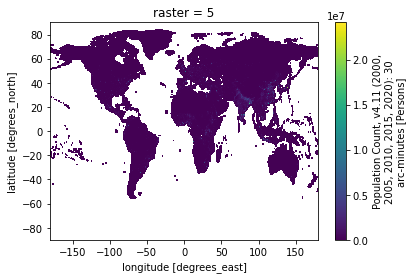

<IPython.core.display.Javascript object>

In [16]:
population_2020.plot()

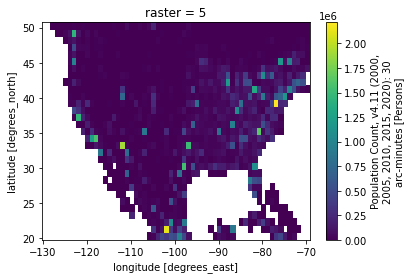

<IPython.core.display.Javascript object>

In [17]:
population_2020.sel(
    latitude=range(20, 50 + 1), longitude=range(-130, -70 + 1), method="nearest"
).plot()

In [18]:
population_2020_iris = population_2020.drop("raster")
population_2020_iris.attrs["units"] = "1"
population_2020_iris.name = "Population"
population_2020_iris["latitude"].attrs["standard_name"] = "latitude"
population_2020_iris["longitude"].attrs["standard_name"] = "longitude"
population_2020_iris = population_2020_iris.to_iris()
display(population_2020_iris)
population_2020_iris.coords()

<iris 'Cube' of Population Count, v4.11 (2000, 2005, 2010, 2015, 2020): 30 arc-minutes / (1) (latitude: 360; longitude: 720)>

[DimCoord(array([ 89.75,  89.25,  88.75,  88.25,  87.75,  87.25,  86.75,  86.25,
         85.75,  85.25,  84.75,  84.25,  83.75,  83.25,  82.75,  82.25,
         81.75,  81.25,  80.75,  80.25,  79.75,  79.25,  78.75,  78.25,
         77.75,  77.25,  76.75,  76.25,  75.75,  75.25,  74.75,  74.25,
         73.75,  73.25,  72.75,  72.25,  71.75,  71.25,  70.75,  70.25,
         69.75,  69.25,  68.75,  68.25,  67.75,  67.25,  66.75,  66.25,
         65.75,  65.25,  64.75,  64.25,  63.75,  63.25,  62.75,  62.25,
         61.75,  61.25,  60.75,  60.25,  59.75,  59.25,  58.75,  58.25,
         57.75,  57.25,  56.75,  56.25,  55.75,  55.25,  54.75,  54.25,
         53.75,  53.25,  52.75,  52.25,  51.75,  51.25,  50.75,  50.25,
         49.75,  49.25,  48.75,  48.25,  47.75,  47.25,  46.75,  46.25,
         45.75,  45.25,  44.75,  44.25,  43.75,  43.25,  42.75,  42.25,
         41.75,  41.25,  40.75,  40.25,  39.75,  39.25,  38.75,  38.25,
         37.75,  37.25,  36.75,  36.25,  35.75,  35.25,

<IPython.core.display.Javascript object>

In [19]:
def get_natural_earth_50m_scale_nearest_last_resort_region_weights(region):
    def _calculate_region_weights(weight_calculator, cube, **kwargs):
        r_stripped = region.replace("Nearest ", "")
        weights_no_pop = weight_calculator.get_weights_array_without_area_weighting(
            r_stripped
        )
        if np.equal(np.sum(weights_no_pop), 0):
            region_mask = regionmask.defined_regions.natural_earth.countries_50[
                [region.split("|")[-1]]
            ]
            assert len(region_mask.centroids) == 1
            centre = region_mask.centroids[0]
            weights_no_pop[
                cube.cube.coord("latitude").nearest_neighbour_index(centre[1]),
                cube.cube.coord("longitude").nearest_neighbour_index(centre[0]),
            ] = 1

        return weights_no_pop

    return _calculate_region_weights


def get_natural_earth_50m_scale_popn_weighted_region_weights(region):
    def _calculate_region_weights(weight_calculator, cube, **kwargs):
        weights_no_pop = weight_calculator.get_weights_array_without_area_weighting(
            region.replace("Popn weighted ", "")
        )
        out = (
            population_2020_iris.regrid(cube.cube, iris.analysis.Linear())
            * weights_no_pop
        )
        out = out.data
        out[np.isnan(out)] = 0

        return out

    return _calculate_region_weights

<IPython.core.display.Javascript object>

In [20]:
regions_incl_pop = []
for region in regions.split(","):
    region_nearest_resort = "Nearest {}".format(region)
    netcdf_scm.weights.WEIGHTS_FUNCTIONS_WITHOUT_AREA_WEIGHTING[
        region_nearest_resort
    ] = get_natural_earth_50m_scale_nearest_last_resort_region_weights(
        region_nearest_resort
    )

    region_incl_pop = "Popn weighted {}".format(region)
    netcdf_scm.weights.WEIGHTS_FUNCTIONS_WITHOUT_AREA_WEIGHTING[
        region_incl_pop
    ] = get_natural_earth_50m_scale_popn_weighted_region_weights(region)
    #     regions_incl_pop.append(region)
    regions_incl_pop.append(region_nearest_resort)
#     regions_incl_pop.append(region_incl_pop)

regions_incl_pop = ",".join(regions_incl_pop)
regions_incl_pop

'Nearest World|Natural Earth 50m|Zimbabwe,Nearest World,Nearest World|Natural Earth 50m|Norfolk Island,Nearest World|Natural Earth 50m|Israel,Nearest World|Natural Earth 50m|Jamaica,Nearest World|Natural Earth 50m|Maldives'

<IPython.core.display.Javascript object>

In [21]:
def plot_weights(weights_to_plot, constraint=None, axes=None, **kwargs):
    for i, (label, weights) in enumerate(weights_to_plot.items()):
        if axes is None:
            ax = plt.figure().add_subplot(111)
        else:
            ax = axes[i]

        weight_cube = example.cube.collapsed("time", iris.analysis.MEAN)
        weight_cube.data = weights
        weight_cube.units = ""
        if constraint is not None:
            weight_cube = weight_cube.extract(constraint)

        plt.sca(ax)

        qplt.pcolormesh(
            weight_cube,
            **kwargs,
        )

        plt.gca().set_title(label)
        plt.gca().coastlines(alpha=0.5)

<IPython.core.display.Javascript object>

In [22]:
example = CMIP6OutputCube()
example.load_data_in_directory(
    "/data/cmip6/CMIP6/ScenarioMIP/CSIRO/ACCESS-ESM1-5/ssp245/r3i1p1f1/Amon/tas/gn/v20191203"
)

<IPython.core.display.Javascript object>

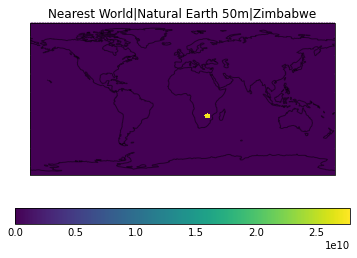

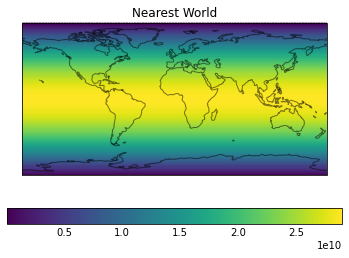

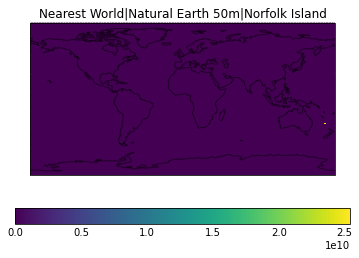

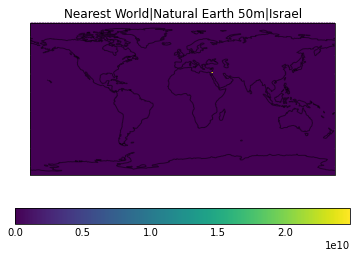

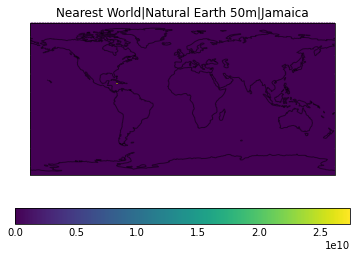

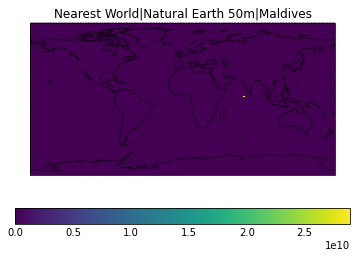

<IPython.core.display.Javascript object>

In [24]:
custom_weights = example.get_scm_timeseries_weights(regions=regions_incl_pop.split(","))
plot_weights(custom_weights)

## Run

In [ ]:
netcdf_scm.crunching._crunch_data(
    "/data/cmip6/CMIP6",
    CRUNCH_DIR,
    "Zebedee Nicholls <zebedee.nicholls@climate-energy-college.org>",
    drs="CMIP6Output",
    regexp=".*(CMIP|ScenarioMIP).*(/ssp|/historical/|/piControl/).*(r1i1p1f1|r2i1p1f1|r3i1p1f1|r1i1p1f2|r1i1p2f1|r1i1p1f3|r4i1p1f1|r10i1p1f1|r11i1p1f1).*Amon.*/tas/.*",
    regions=regions_incl_pop,
    data_sub_dir="netcdf-scm-crunched",
    force=False,
    small_number_workers=60,
    small_threshold=100,
    medium_number_workers=20,
    medium_threshold=400,
    force_lazy_threshold=1000,
    cell_weights=None,
)

In [ ]:
checker = "./country-crunch-country-weighted/netcdf-scm-crunched/CMIP6/ScenarioMIP/CSIRO/ACCESS-ESM1-5/ssp245/r3i1p1f1/Amon/tas/gn/v20191203/netcdf-scm_tas_Amon_ACCESS-ESM1-5_ssp245_r3i1p1f1_gn_201501-210012.nc"
checker = netcdf_scm.io.load_scmrun(checker)
checker["popn_weighted"] = checker["region"].str.contains("Popn")
checker["geographic_region"] = checker["region"].str.replace("Popn weighted ", "")

ax = plt.figure(figsize=(12, 8)).add_subplot(111)
checker.time_mean("AC").lineplot(hue="geographic_region", style="popn_weighted", ax=ax)

In [ ]:
!find /data/cmip6/CMIP6/CMIP -name 'KIOST-ESM' -type d

In [ ]:
!ls /data/cmip6/CMIP6/ScenarioMIP/NCAR/CESM2

In [ ]:
!find /data/cmip6/CMIP6/CMIP/KIOST/KIOST-ESM -type f -name 'tas_Amon*'

In [ ]:
!find /data/cmip6/CMIP6/ScenarioMIP -name 'KIOST-ESM' -type d

In [ ]:
!find /data/cmip6/CMIP6/ScenarioMIP/KIOST/KIOST-ESM -type f -name 'tas_Amon*_ssp245_*'

In [ ]:
!find /data/cmip6/CMIP6/ScenarioMIP/CCCR-IITM/IITM-ESM -type f -name '*_ssp245_*'

In [ ]:
!find {CRUNCH_DIR} -name '*_ssp245_*' -type f  #| wc -l